In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [3]:
tf.random.set_seed(12345)

In [4]:
# pip install -U numpy==1.18.5

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
f = h5py.File("autobuses_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [7]:
len(scaled_X)*0.8

16627.2

In [8]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

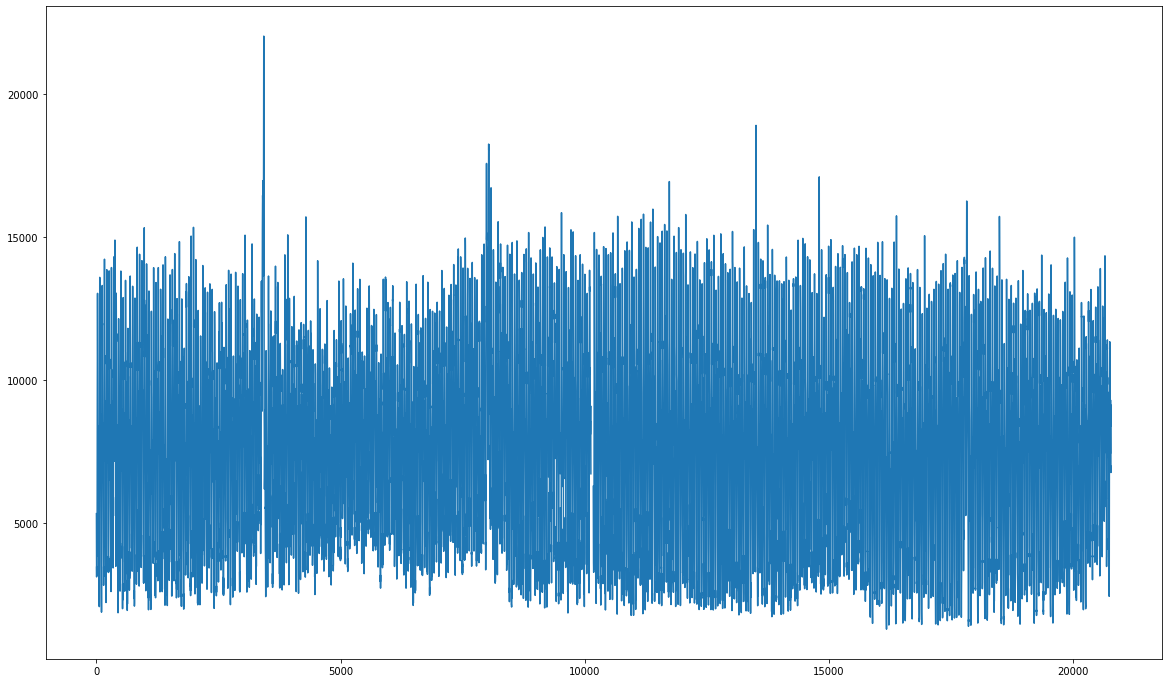

In [9]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [10]:
def partitionSet(test_fraction, data, partitions):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partitions/100)*lenX):int((partitions/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partitions/100)*lenX)-1],data[int((partitions/100)*lenX)+test_size:]))
    train_df[int((partitions/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

partitions=75

for i in range(1, partitions):
    [train_df,test_df] = partitionSet(0.25,scaled_X,i)
    train_dataf.append(train_df)
    test_dataf.append(test_df)

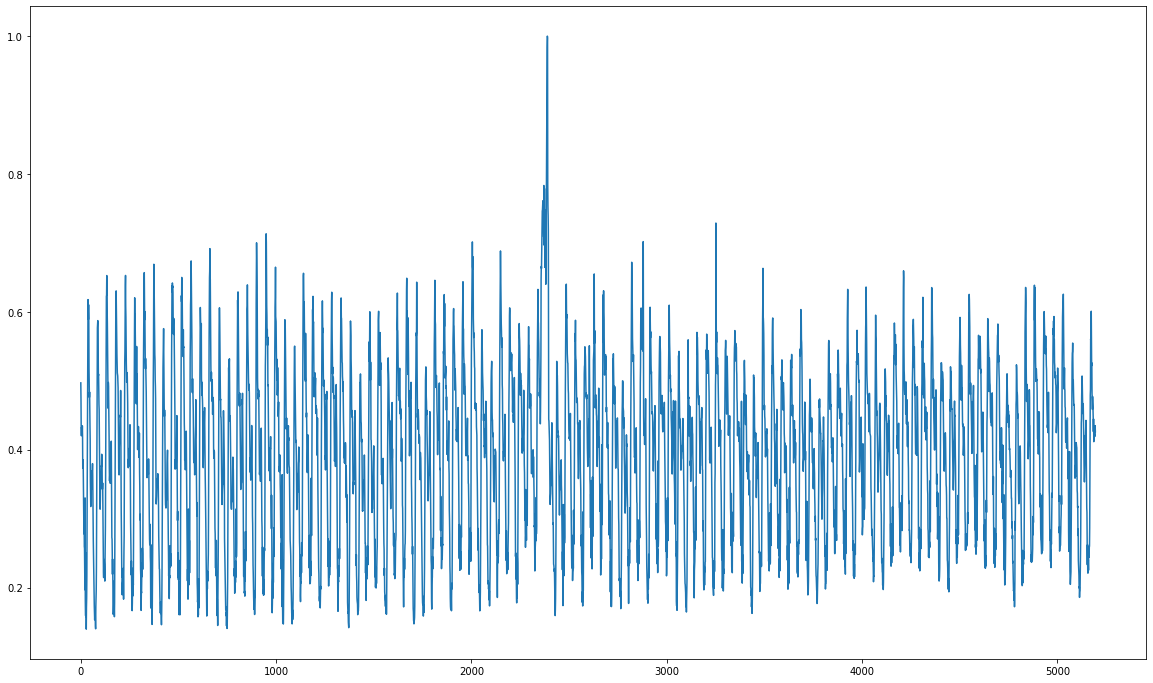

In [18]:
plt.plot(test_dataf[4])

In [11]:
def Dataset(train, test, timesteps):
    X_train = ma.array([train[t:t+timesteps] for t in range(0,len(train)-timesteps)])
    y_train = train[timesteps:, :]
    X_test = ma.array([test[t:t+timesteps] for t in range(0,len(test)-timesteps)])
    y_test = test[timesteps:, :]
    return X_train, y_train, X_test, y_test

train_X_data = []
train_Y_data = []
test_X_data = []
test_Y_data = []


for j in range(0, len(train_dataf)):
    [train_X_dates,train_Y_dates,test_X_dates,test_Y_dates]=Dataset(train_dataf[j],test_dataf[j], 24)
    train_X_data.append(train_X_dates)
    train_Y_data.append(train_Y_dates)
    test_X_data.append(test_X_dates)
    test_Y_data.append(test_Y_dates)

In [12]:
with open('train_X_data.npy', 'wb') as f:
    np.save(f, [train_X_data[i] for i in range(0, len(train_dataf))])

In [13]:
with open('train_Y_data.npy', 'wb') as f:
    np.save(f, [train_Y_data[i] for i in range(0, len(train_dataf))])

In [14]:
with open('test_X_data.npy', 'wb') as f:
    np.save(f, [test_X_data[i] for i in range(0, len(train_dataf))])

In [15]:
with open('test_Y_data.npy', 'wb') as f:
    np.save(f, [test_Y_data[i] for i in range(0, len(train_dataf))])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [17]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=12, min_delta=0.00001, mode='min')

In [18]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit, earlystopping, i):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam')
    X_ = ma.filled(train_X_data[i],0)
    Y_ = ma.filled(train_Y_data[i],0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False,
                      callbacks=[earlystopping])
    return model, MODEL

In [20]:
df_train = []
df_validation = []
models = []
MODELS = []

datasets = np.arange(0,partitions-1)

for j in datasets:
    [model, MODEL] = LSTM_function(64,np.shape(train_X_data[0])[1], 1, 0.1, 200, 128, 0.2, early_stopping, j)
    df_train.append(MODEL.history['loss'])
    df_validation.append(MODEL.history['val_loss'])
    models.append(model)
    MODELS.append(MODEL)

Epoch 1/200
98/98 [==============================] - 9s 31ms/step - loss: 0.0307 - val_loss: 0.0202
Epoch 2/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0206 - val_loss: 0.0154
Epoch 3/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0163 - val_loss: 0.0131
Epoch 4/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0147 - val_loss: 0.0123
Epoch 5/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0132 - val_loss: 0.0125
Epoch 6/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0104 - val_loss: 0.0091
Epoch 7/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 8/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0064 - val_loss: 0.0090
Epoch 9/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0062 - val_loss: 0.0086
Epoch 10/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0061 - val_loss: 0.0081

98/98 [==============================] - 2s 16ms/step - loss: 0.0112 - val_loss: 0.0079
Epoch 4/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0095 - val_loss: 0.0072
Epoch 5/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 6/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0056 - val_loss: 0.0065
Epoch 7/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 8/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 9/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 10/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 11/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 12/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 13/

98/98 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 63/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 64/200
98/98 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 65/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 66/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 67/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 68/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 69/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 70/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 71/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epo

98/98 [==============================] - 2s 18ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 31/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 32/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 33/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 34/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 35/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 36/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 37/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 38/200
98/98 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 39/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0028 - val_loss: 0.0018
Epo

Epoch 8/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 9/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 10/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 11/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 12/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 13/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 14/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 15/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 16/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 17/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0032 - val_loss:

98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 107/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 108/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 109/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 110/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 111/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 112/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 113/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 114/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 115/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0

98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 61/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 62/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 63/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 64/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 65/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 66/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 67/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 68/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 69/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0014
Epo

98/98 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 28/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 29/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 30/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 31/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 32/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 33/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 34/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 35/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 36/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0024 - val_loss: 0.0015
Epo

98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 84/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 85/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 86/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 87/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 88/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 89/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 90/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 91/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 92/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0012
Epo

Epoch 17/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 18/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 19/200
98/98 [==============================] - 2s 17ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 20/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 21/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 22/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 23/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 24/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 25/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 26/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0030 - val_los

Epoch 3/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 4/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0108 - val_loss: 0.0073
Epoch 5/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0085 - val_loss: 0.0054
Epoch 6/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 7/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 8/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 9/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 10/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 11/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 12/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0041 - val_loss: 0.00

98/98 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 62/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 63/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 64/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 65/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 66/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 67/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 68/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 69/200
98/98 [==============================] - 2s 16ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 70/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0015
Epo

98/98 [==============================] - 1s 14ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 16/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 17/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 18/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 19/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 20/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 21/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 22/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 23/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 24/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.0029
Epo

Epoch 96/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 9.8550e-04
Epoch 97/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 9.7622e-04
Epoch 98/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0016 - val_loss: 9.5193e-04
Epoch 99/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 100/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 101/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 102/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 1/200
98/98 [==============================] - 10s 33ms/step - loss: 0.0341 - val_loss: 0.0189
Epoch 2/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0209 - val_loss: 0.0168
Epoch 3/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0

98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 76/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 77/200
98/98 [==============================] - 2s 15ms/step - loss: 0.0019 - val_loss: 9.8872e-04
Epoch 78/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 79/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 80/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 81/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 82/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 83/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0018 - val_loss: 9.6793e-04
Epoch 84/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.

98/98 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 62/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 63/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 64/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 65/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 66/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 67/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 68/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 69/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 70/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0011
Epo

98/98 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 22/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 23/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 24/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 25/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 26/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 27/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 28/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 29/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 30/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0019
Epo

98/98 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 80/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 81/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 82/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 83/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 84/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 85/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 86/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 87/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 88/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0010
Epo

98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 113/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 114/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 115/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 116/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 117/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 118/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 119/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 120/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 121/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0

Epoch 42/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 43/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 44/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 45/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 46/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 47/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 48/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 49/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 50/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 51/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.00

98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 66/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 67/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 68/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 69/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 70/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 71/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 72/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 73/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 74/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 75/200


Epoch 113/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 8.2764e-04
Epoch 114/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.8755e-04
Epoch 115/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.4217e-04
Epoch 116/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.2810e-04
Epoch 117/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.5875e-04
Epoch 118/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.1619e-04
Epoch 119/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.5955e-04
Epoch 120/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.9452e-04
Epoch 121/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.4756e-04
Epoch 122/200
98/98 [==============================] - 

98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 71/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 72/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.9987e-04
Epoch 73/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 74/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 75/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.9932e-04
Epoch 76/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 77/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.8244e-04
Epoch 78/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 9.9046e-04
Epoch 79/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0

98/98 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 39/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 40/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 41/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 42/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 43/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 44/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 45/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 46/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 47/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch

98/98 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 18/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 19/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 20/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 21/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 22/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 23/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 24/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 25/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 26/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 27/200

98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 29/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 30/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 31/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 32/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 33/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 34/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 35/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 36/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 37/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 38/200


98/98 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 14/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 15/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 16/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 17/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 18/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 19/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 20/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 21/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 22/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 23/200


Epoch 95/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 96/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 97/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 1/200
98/98 [==============================] - 7s 25ms/step - loss: 0.0315 - val_loss: 0.0200
Epoch 2/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0199 - val_loss: 0.0196
Epoch 3/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0196 - val_loss: 0.0191
Epoch 4/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0187 - val_loss: 0.0172
Epoch 5/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0146 - val_loss: 0.0120
Epoch 6/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0105 - val_loss: 0.0086
Epoch 7/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 

98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 81/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 82/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 83/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 84/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 85/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 86/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 87/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 88/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 89/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 90/200


98/98 [==============================] - 1s 9ms/step - loss: 0.0137 - val_loss: 0.0109
Epoch 5/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 6/200
98/98 [==============================] - 1s 8ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 7/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 8/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 9/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 10/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 11/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 12/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 13/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 14/200
98/98

Epoch 86/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.6043e-04
Epoch 87/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 88/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.9667e-04
Epoch 89/200
98/98 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 90/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 9.4585e-04
Epoch 91/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 92/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 93/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 94/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 95/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0013 - val_l

Epoch 71/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.7207e-04
Epoch 72/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 9.5046e-04
Epoch 73/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 9.2395e-04
Epoch 74/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.4537e-04
Epoch 75/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 9.5535e-04
Epoch 76/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.9273e-04
Epoch 77/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.8287e-04
Epoch 78/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 8.9150e-04
Epoch 79/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 9.1806e-04
Epoch 80/200
98/98 [==============================] - 1s 10ms/

Epoch 54/200
98/98 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 55/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 56/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 57/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 58/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 59/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.9302e-04
Epoch 60/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 61/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 62/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 9.9596e-04
Epoch 63/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss:

98/98 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 44/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 45/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 46/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 47/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 48/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 49/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 50/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 51/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 52/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 53/200


Epoch 49/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 50/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 51/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 52/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 53/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 54/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 55/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 56/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 57/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 58/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0

98/98 [==============================] - 1s 10ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 11/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 12/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 13/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 14/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 15/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 16/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 17/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 18/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 19/200
98/98 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 

98/98 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 69/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 70/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 71/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 72/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 73/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 74/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 75/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 76/200
98/98 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 77/200
98/98 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.0011
Epo

98/98 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 44/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 45/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 46/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 47/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 48/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 49/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 50/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 51/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 52/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0018
Epo

Epoch 124/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 125/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 126/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 127/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 128/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 129/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 130/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 131/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 132/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 133/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0014

98/98 [==============================] - 1s 13ms/step - loss: 0.0176 - val_loss: 0.0138
Epoch 4/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0135 - val_loss: 0.0112
Epoch 5/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0100 - val_loss: 0.0082
Epoch 6/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0068 - val_loss: 0.0059
Epoch 7/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 9/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 10/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 11/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 12/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 13/

98/98 [==============================] - 1s 14ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 45/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 46/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 47/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 48/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 49/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 50/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 51/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 52/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 53/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0024 - val_loss: 0.0017
Epo

98/98 [==============================] - 1s 14ms/step - loss: 0.0084 - val_loss: 0.0062
Epoch 7/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 8/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 9/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 10/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 11/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 12/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 13/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 14/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 15/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 

Epoch 48/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 49/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 50/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 51/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 52/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 53/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 54/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 55/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 56/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 57/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0020 - val_los

98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 40/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 41/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 42/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 43/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 44/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 45/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 46/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 47/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 48/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0012
Epo

98/98 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 97/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 98/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 99/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 100/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 101/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 102/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 103/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 104/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 105/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 0.00

98/98 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 45/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 46/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 47/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 48/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 49/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 50/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 51/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 52/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 53/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0026 - val_loss: 0.0021
Epo

98/98 [==============================] - 1s 15ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 12/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 13/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 14/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 15/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 16/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 17/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 18/200
98/98 [==============================] - 1s 15ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 19/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 20/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0035 - val_loss: 0.0028
Epo

98/98 [==============================] - 1s 13ms/step - loss: 0.0152 - val_loss: 0.0111
Epoch 4/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0133 - val_loss: 0.0099
Epoch 5/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0118 - val_loss: 0.0090
Epoch 6/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 7/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0087 - val_loss: 0.0064
Epoch 8/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 9/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 10/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 11/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 12/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 13/

98/98 [==============================] - 1s 12ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 13/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 14/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 15/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 16/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 17/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 18/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 19/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 20/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 21/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0018
Epo

98/98 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 29/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 30/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 31/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 32/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 33/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 34/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 35/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 36/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 37/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0013
Epo

98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 41/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 42/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 43/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 44/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 45/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 46/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 47/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 48/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 49/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0013
Epo

98/98 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 53/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 54/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 55/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 56/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 57/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 58/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 59/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 60/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 61/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0011
Epo

98/98 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 65/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 66/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 67/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 68/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 69/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 70/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 71/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 72/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 73/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0022 - val_loss: 0.0015
Epo

98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 53/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 54/200
98/98 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 55/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 56/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 57/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 58/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 59/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 60/200
98/98 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 61/200
98/98 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0012
Epo

In [21]:
for i in datasets:
    models[i].save('/home/costa/JoaoModelsForAlicante/AutoBus/models/AutobusModel'+str(i)+'.h5')

In [ ]:
for i in datasets:
    models[i].save('/home/costa/JoaoModelsForAlicante/AutoBus/MODELS/AutobusModel'+str(i)+'.h5')

In [22]:
len(df_train[8])

91

In [23]:
train_performance = []
for i in datasets:
    train_performance.append(np.array(df_train[i]))

In [24]:
val_performance = []
for i in datasets:
    val_performance.append(np.array(df_validation[i]))

In [25]:
with open('train_performance.npy', 'wb') as f:
    np.save(f, [train_performance[i] for i in datasets])

In [26]:
with open('val_performance.npy', 'wb') as f:
    np.save(f, [val_performance[i] for i in datasets])

In [2]:
import re #python regular expression matching module
script = re.sub(r'# In\[.*\]:\n','',open('3.0-Model.py').read())
with open('3.0-ModelScript.py','w') as fh:
    fh.write(script)